In [ ]:
# !pip install gensim distance fuzzywuzzy
# 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk 
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

### EDA

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# data = df.sample(3000, random_state = 2)
data = df.sample(10000)

In [6]:
data.drop(columns = 'id').duplicated().sum()

0

In [7]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
data.dropna(inplace=True)

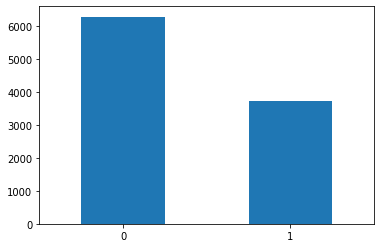

In [9]:
data['is_duplicate'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Basic Feature Engineering

In [10]:
data['q1_len'] = data['question1'].apply(len)
data['q2_len'] = data['question2'].apply(len)

In [11]:
data['q1_word_ct'] = data['question1'].apply(lambda x: len(x.split()))
data['q2_word_ct'] = data['question2'].apply(lambda x: len(x.split()))

In [12]:
def common_words(row):
    w_q1 = set(map(lambda w: w.lower().strip(), row['question1'].split()))
    w_q2 = set(map(lambda w: w.lower().strip(), row['question2'].split()))
    return len(w_q1 & w_q2)    

In [13]:
data['common_words'] = data.apply(common_words, axis = 1)

In [14]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [15]:
data['word_total'] = data.apply(total_words, axis=1)

In [16]:
data['word_share'] = round(data['common_words']/data['word_total'],2)

#### EDA on new features

minimum characters 1
maximum characters 343
average num of characters 59


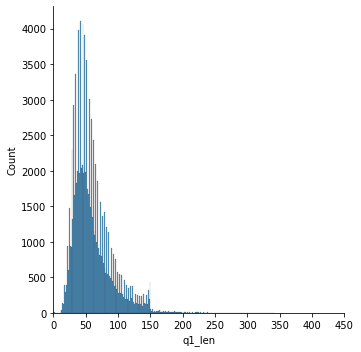

In [169]:
# Analysis of features
sns.displot(data['q1_len'])
plt.xlim((0, 450))
print('minimum characters',data['q1_len'].min())
print('maximum characters',data['q1_len'].max())
print('average num of characters',int(data['q1_len'].mean()))

minimum characters 4
maximum characters 1151
average num of characters 60


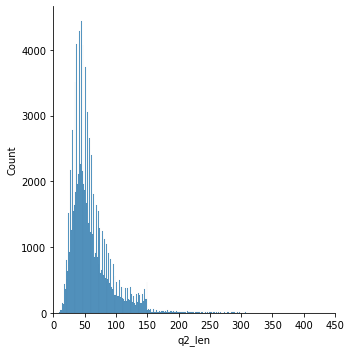

In [170]:
# Analysis of features
sns.displot(data['q2_len'])
plt.xlim((0, 450))
print('minimum characters',data['q2_len'].min())
print('maximum characters',data['q2_len'].max())
print('average num of characters',int(data['q2_len'].mean()))

minimum words 1
maximum words 63
average num of words 10


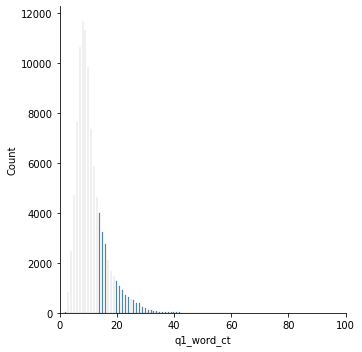

In [171]:
sns.displot(data['q1_word_ct'])
plt.xlim((0, 100))
print('minimum words',data['q1_word_ct'].min())
print('maximum words',data['q1_word_ct'].max())
print('average num of words',int(data['q1_word_ct'].mean()))

minimum words 1
maximum words 237
average num of words 11


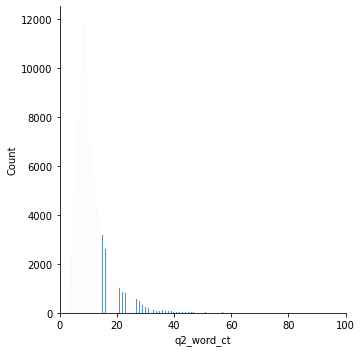

In [172]:
sns.displot(data['q2_word_ct'])
plt.xlim((0, 100))
print('minimum words',data['q2_word_ct'].min())
print('maximum words',data['q2_word_ct'].max())
print('average num of words',int(data['q2_word_ct'].mean()))

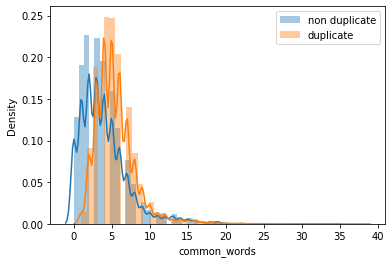

In [173]:
# common words
sns.distplot(data[data['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(data[data['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

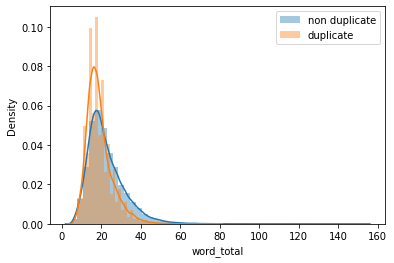

In [174]:
# total words
sns.distplot(data[data['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(data[data['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

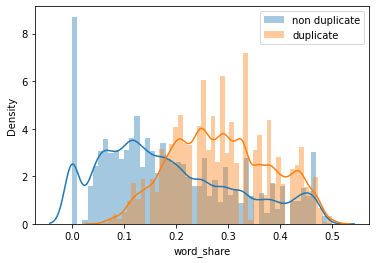

In [175]:
# total words
sns.distplot(data[data['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(data[data['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [176]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_ct,q2_word_ct,common_words,word_total,word_share
213354,213354,318654,318655,What are the qualities does Mayanti Langer lik...,What's it like to cruise to Aruba?,0,64,34,11,7,1,17,0.06
61952,61952,48440,108075,What is the myth behind a left eye twitching?,What superstitious beliefs surround an eye twi...,1,45,53,9,7,3,16,0.19
81633,81633,138573,138574,Which are the best websites for economic news？,What's the best economics textbook for self-st...,0,46,50,8,7,3,15,0.20
221032,221032,328278,328279,My husband is applying for an H1B visa. What i...,Is there any issue with “dual intent” when I g...,0,127,150,23,32,4,49,0.08
55383,55383,97637,97638,"In the World of newspapers, what is ""Advance C...",Which is a suitable inpatient drug and alcohol...,0,54,81,9,14,2,23,0.09


In [17]:
final_df = data.iloc[:, 5:]
final_df.head()

,is_duplicate,q1_len,q2_len,q1_word_ct,q2_word_ct,common_words,word_total,word_share
111737,0,70,69,14,14,12,26,0.46
94622,0,29,27,5,5,3,10,0.30
94027,0,42,39,7,6,0,13,0.00
344341,0,49,49,8,9,1,17,0.06
149821,1,33,33,6,7,3,13,0.23


### Advance Features

In [18]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
          

In [19]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [20]:
token_features = data.apply(fetch_token_features, axis=1)

data["cwc_min"]       = list(map(lambda x: x[0], token_features))
data["cwc_max"]       = list(map(lambda x: x[1], token_features))
data["csc_min"]       = list(map(lambda x: x[2], token_features))
data["csc_max"]       = list(map(lambda x: x[3], token_features))
data["ctc_min"]       = list(map(lambda x: x[4], token_features))
data["ctc_max"]       = list(map(lambda x: x[5], token_features))
data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
data["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [21]:
import distance
# Advanced Features
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = 0 if not len(strs) else len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [22]:
length_features = data.apply(fetch_length_features, axis=1)

data['abs_len_diff'] = list(map(lambda x: x[0], length_features))
data['mean_len'] = list(map(lambda x: x[1], length_features))
data['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [23]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [24]:
fuzzy_features = data.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

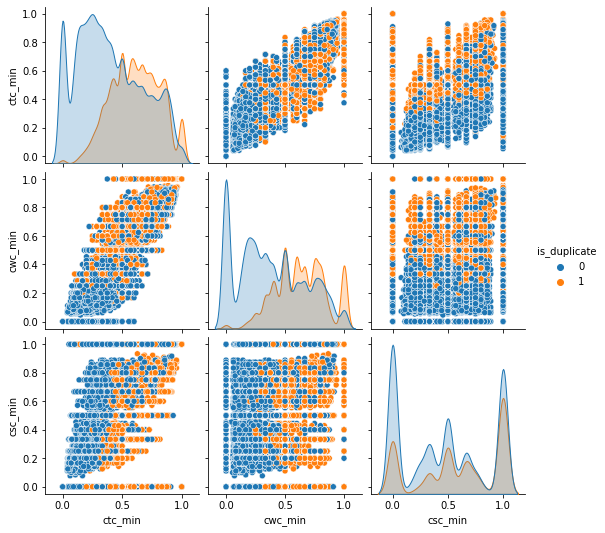

In [185]:
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

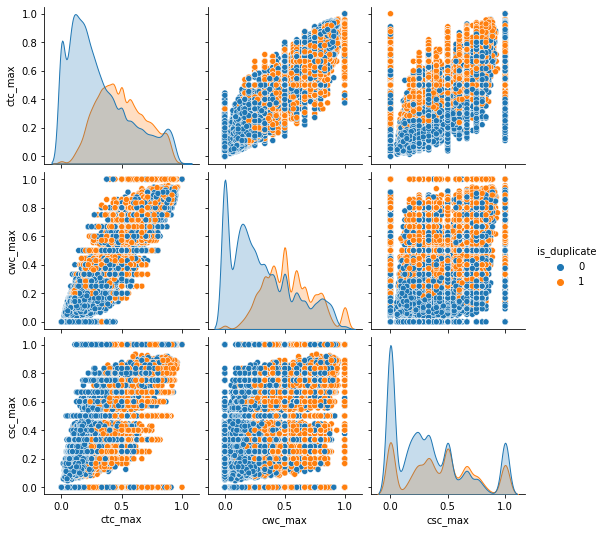

In [186]:
sns.pairplot(data[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

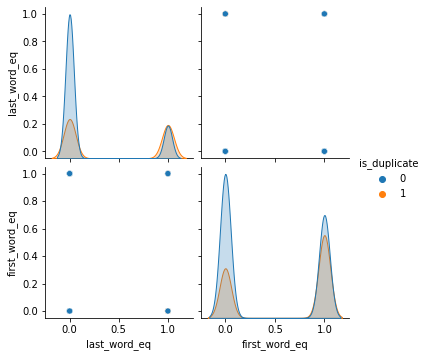

In [187]:
sns.pairplot(data[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

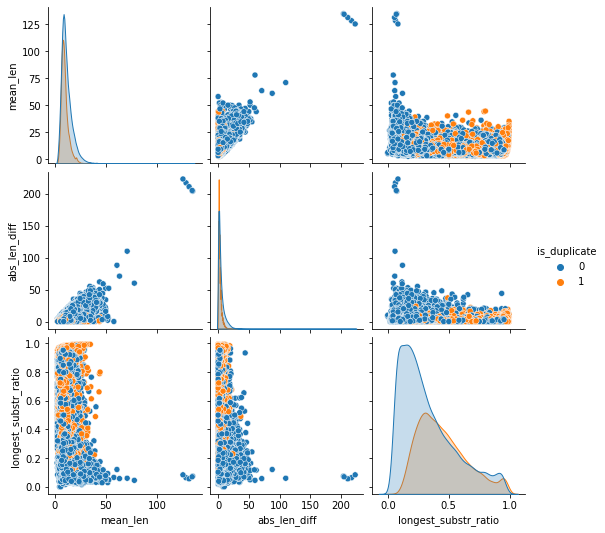

In [188]:
sns.pairplot(data[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

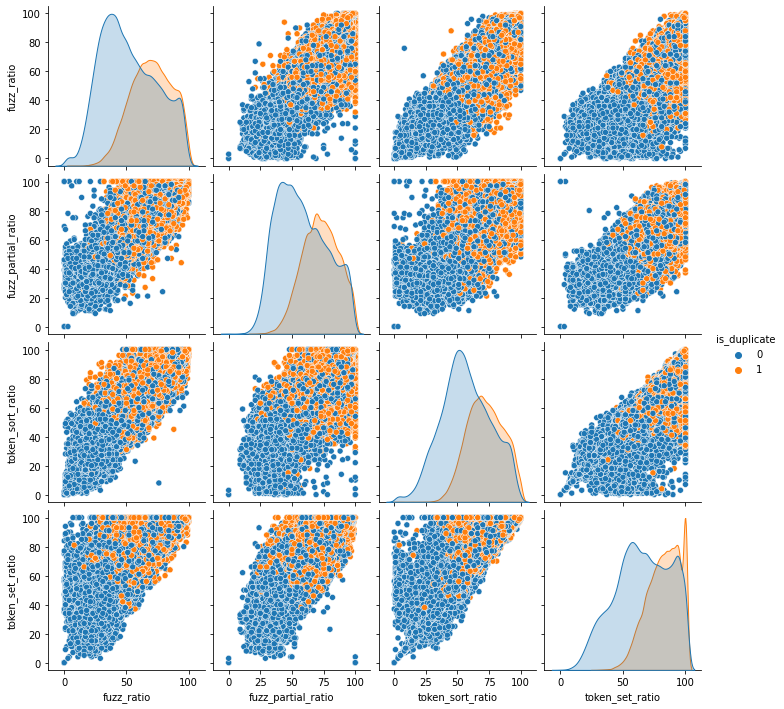

In [189]:
sns.pairplot(data[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [25]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(data[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = data['is_duplicate'].values

In [191]:
# from sklearn.manifold import TSNE

# tsne2d = TSNE(
#     n_components=2,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [192]:
# x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# # draw the plot in appropriate place in the grid
# sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])


In [193]:
# tsne3d = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [194]:
# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# trace1 = go.Scatter3d(
#     x=tsne3d[:,0],
#     y=tsne3d[:,1],
#     z=tsne3d[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = y,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# d=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=d, layout=layout)
# py.iplot(fig, filename='3DBubble')

In [195]:
# data.head()

### Sentences Embeddings

In [26]:
final_df = data.iloc[:, 5:]

In [27]:
# tokenized_sentences_q1

In [29]:
from gensim.models import Word2Vec

# Assuming 'processed_questions' contains preprocessed text
X = data[['question1', 'question2']]

# Tokenize the sentences
tokenized_sentences_q1 = X['question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['question2'].apply(lambda x: str(x).split())
text = pd.concat([tokenized_sentences_q1, tokenized_sentences_q2], axis = 0)
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=text, vector_size=3000, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_combined = pd.DataFrame(np.concatenate((X_q1, X_q2), axis=1))

In [30]:
final_df = pd.concat([final_df.reset_index(drop=True), X_combined], axis=1)
final_df.head()

,is_duplicate,q1_len,q2_len,q1_word_ct,q2_word_ct,common_words,word_total,word_share,cwc_min,cwc_max,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0,70,69,14,14,12,26,0.46,0.833319,0.833319,...,-0.089780,-0.014304,0.090623,-0.004209,0.134047,0.192301,-0.019022,-0.273611,-0.100909,0.022094
1,0,29,27,5,5,3,10,0.30,0.499988,0.499988,...,-0.079989,-0.023003,0.096276,0.003709,0.150786,0.170840,-0.018358,-0.254313,-0.074572,0.012570
2,0,42,39,7,6,0,13,0.00,0.000000,0.000000,...,-0.053261,-0.004152,0.053625,0.000869,0.094951,0.103922,-0.013329,-0.154653,-0.050537,0.023669
3,0,49,49,8,9,1,17,0.06,0.199996,0.166664,...,-0.070860,-0.032891,0.088032,-0.003572,0.071586,0.221820,-0.008143,-0.251177,-0.135031,-0.029997
4,1,33,33,6,7,3,13,0.23,0.749981,0.749981,...,-0.085710,-0.021044,0.092016,-0.017224,0.129649,0.196694,-0.015808,-0.254794,-0.104156,0.007851


In [199]:
# ques_df = data[['question1','question2']]

In [200]:
# questions = pd.concat([data['question1'],data['question2']], axis=0) 
# cv = CountVectorizer(max_features = 3000)
# cv =  cv.fit_transform(questions)
# q1, q2 = np.vsplit(cv.toarray(), 2)

In [201]:
# temp_df1 = pd.DataFrame(q1, index= ques_df.index)
# temp_df2 = pd.DataFrame(q2, index= ques_df.index)
# temp_df = pd.concat([temp_df1, temp_df2], axis=1)
# final_df = pd.concat([final_df, temp_df], axis=1)
final_df = pd.concat([final_df.reset_index(drop = True), X_combined], axis=1)

print(final_df.shape)
final_df.tail()

(100000, 6023)



KeyboardInterrupt



In [31]:
final_df.isnull().sum()

is_duplicate    0
q1_len          0
q2_len          0
q1_word_ct      0
q2_word_ct      0
               ..
5995            0
5996            0
5997            0
5998            0
5999            0
Length: 6023, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [34]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train,y_train)
y_pred_1 = rf.predict(X_test)
accuracy_score(y_test,y_pred_1)

0.7475

In [36]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_2 = xgb.predict(X_test)
accuracy_score(y_test,y_pred_2)

0.7645

In [37]:
confusion_matrix(y_test, y_pred_1)

array([[1117,  180],
       [ 325,  378]], dtype=int64)

In [38]:
confusion_matrix(y_test, y_pred_2)

array([[1059,  238],
       [ 233,  470]], dtype=int64)

In [39]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [40]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    # q1_bow = cv.transform([q1]).toarray()

    q1_tokens = q1.split()
    q1_bow = get_sentence_vector(q1_tokens, word2vec_model).reshape(1, -1)
    
    # bow feature for q2
    # q2_bow = cv.transform([q2]).toarray()
    
    q2_tokens = q2.split()
    q2_bow =  get_sentence_vector(q2_tokens, word2vec_model).reshape(1, -1)
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [41]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [42]:
xgb.predict(query_point_creator(q4,q3))

array([0])

In [44]:
import pickle

pickle.dump(xgb,open('model.pkl','wb'))
pickle.dump(word2vec_model,open('Sentence_Embeddings.pkl','wb'))